In [9]:
import os
import preprocessing

from gensim import corpora

In [13]:
#texts = preprocessing.corpus_tokens()
#dictionary = corpora.Dictionary(texts)
flat_metadata = preprocessing.flat_unique()
summaries = [paper['summary'].replace('\n', ' ') for paper in flat_metadata]

# Sample
summaries[0][:200]

'Time series forecasting is a crucial component of many important applications, ranging from forecasting the stock markets to energy load prediction. The high-dimensionality, velocity and variety of th'

In [35]:
import spacy
from spacy.lang.en.examples import sentences

nlp = spacy.load('en_core_web_md')

In [68]:
from tqdm import tqdm

corpus_orgs = []
for i in tqdm(range(len(summaries))):
    doc = nlp(summaries[i])
    doc_orgs = []
    for entity in doc.ents:
        #print(entity.text, entity.label_)
        if entity.label_ == 'ORG':
            text = entity.text
            #print(text)
            doc_orgs.append(text)
    corpus_orgs.append(doc_orgs)

100%|██████████| 9232/9232 [07:08<00:00, 21.55it/s]


100%|██████████| 49/49 [04:59<00:00,  4.97s/it]


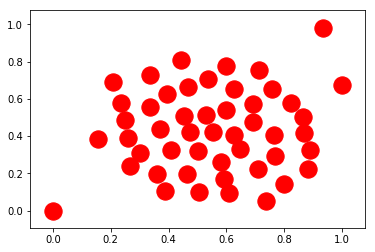

In [95]:
import time
import networkx as nx
from networkx.drawing.nx_pylab import draw_networkx, draw
import matplotlib.pyplot as plt


G = nx.Graph()
#G.add_edge('A', 'B', weight=4)
#nx.shortest_path(G, 'A', 'B', weight='weight')
sim = []
N = 50
#for i in range(1, len(summaries)):
for i in tqdm(range(1, N)):
    for j in range(1, N):
        # Determine semantic similarities
        doc1 = nlp(summaries[i])
        doc2 = nlp(summaries[j])
        similarity = doc1.similarity(doc2)
        
        G.add_edge(str(j), str(i), weight=1-similarity)
        
try:
    draw_networkx(G)
except:
    pass
finally:
    plt.draw()  # pyplot draw()
#plt.show()

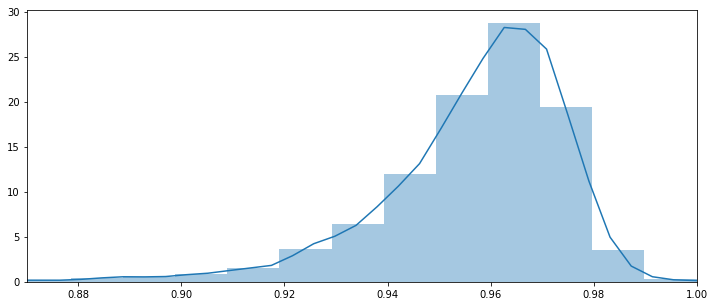

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))
plt.xlim(0.87, 1)
sns.distplot(sim)
plt.show()